# DATA PREPARATION

## 00. INIT

Treating the data after profiling and analysing the necessary transformations to be applied, step by step:
1. Missing Values;
2. Dummification;
3. Outliers;
4. Feature Engineering:
    - Dates Treatment    

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pandas.plotting import register_matplotlib_converters
from ds_charts import get_variable_types
import midstep_evaluation_functions as midfunc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pandas import DataFrame, concat
from matplotlib.pyplot import subplots, show, figure, title, savefig
from seaborn import heatmap
import matplotlib.pyplot as plt
import ds_charts as ds
from imblearn.over_sampling import SMOTE
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from numpy import arange, ndarray, newaxis, set_printoptions, isnan

%run p00_settings.ipynb

In [2]:
register_matplotlib_converters()

data = pd.read_csv(project_path + data_file, na_values='', sep=',', parse_dates=['founded_at', 'closed_at','first_funding_at', 'last_funding_at'], infer_datetime_format=True) 
data.shape

(923, 49)

In [3]:
cat_vars = data.select_dtypes(include='object')
data[cat_vars.columns] = data.select_dtypes(['object']).apply(lambda x: x.astype('category'))

<u>closed_at</u> Transformation of NaT values to <u>np.datetime64('2020')</u> in order to manipualte them:

In [4]:
data_in = data.copy(deep=True)
data_in['closed_at'] = pd.to_datetime(np.where(np.isnat(data_in['closed_at']), np.datetime64('2020'), data_in['closed_at'])).astype(np.int64)

Drop unused columns for modelling:
1. <u>Unnamed: 06</u>: This variable a combination of "city" and "zipcode", so we dropped it since we don't lose any information;
2. <u>state_code.1</u>: This variable is exactly the same as "state_code" and only has 1 missing value, so we dropped the column.
3. <u>id</u>: This variable is a primary key, so it was dropped.
4. <u>object_id</u>: This variable is exactly the same as "id", so we dropped the column.
5. <u>labels</u>: This variable has a direct correspondence to the target variable "status", so we dropped it.

In [5]:
data_in = data_in.drop(columns=dropped_columns)
data_in.shape

(923, 44)

## 01. Missing Values Treatment
Treatments done:
1. <u>data_missings_1</u>: Take out the missing value records;
2. <u>data_missings_2</u>:Substitute with 0;
3. <u>data_missings_3</u>:Substitute by the average value.

In [6]:
data_missings_1 = data_in.copy(deep=True)
data_missings_1 = data_missings_1.dropna(subset = ['age_first_milestone_year','age_last_milestone_year', 'closed_at'])
data_missings_1.shape

(771, 44)

In [7]:
import csv  

header_closed_at = ['closed_at']
mean_closed = int(data_missings_1.closed_at.mean())

with open(project_path + 'data/mean_closed_at.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header_closed_at)

    # write the data
    writer.writerow([mean_closed])

In [8]:
data_missings_2 = data_in.copy(deep=True)
data_missings_2['age_first_milestone_year'].replace(np.nan,0, inplace=True)
data_missings_2['age_last_milestone_year'].replace(np.nan,0, inplace=True)
data_missings_2['closed_at'] = np.where(data_missings_2['closed_at'] == 1577836800000000000, 0, data_missings_2['closed_at'])

In [9]:
data_missings_3 = data_in.copy(deep=True)
data_missings_3['age_first_milestone_year'].replace(np.nan, data_missings_3.age_first_milestone_year.mean(), inplace=True)
data_missings_3['age_last_milestone_year'].replace(np.nan, data_missings_3.age_last_milestone_year.mean(), inplace=True)
data_missings_3['closed_at'] = np.where(data_missings_3['closed_at'] == 1577836800000000000, mean_closed, data_missings_3['closed_at'])

Dates to Numeric Treatment:

In [10]:
for variable in data_in.columns:
    if data_in[variable].dtype == 'datetime64[ns]':
        data_missings_1[variable] = pd.to_datetime(data_missings_1[variable]).astype(np.int64)
        data_missings_2[variable] = pd.to_datetime(data_missings_2[variable]).astype(np.int64)
        data_missings_3[variable] = pd.to_datetime(data_missings_3[variable]).astype(np.int64)

In [11]:
#Choose the missings filling strategy dataset:
exec('data_mv =' + missings_data)
data_mv.shape

(923, 44)

## 02. Dummification Treatment
Dealing with nominal variables demands additional transformations for some of mining techniques, in particular the ones depending on similarity measures, where the distance between the distinct values is of major importance. The easiest transformation of such variables is called dummification, and consists on creating a new variable for each possible value from the original one, removing it from the dataset. Note, however, that this shouldn't be applied to the class variable, since it will transform a simple multi label classification problem into a multiclass problem.

DO ONLY FOR NOMINAL SYMBOLIC VARIABLES
1. Dummify all nominal vars;
2. Drop nominal vars and keep the treated dummified nominal vars (which keeps the higher observed values of each variable and creates a column for the other_observed_values).


In [12]:
variable_types = get_variable_types(data_mv)
numeric_vars = variable_types['numeric']
symbolic_vars = variable_types['symbolic']
boolean_vars = variable_types['binary']
nominal_vars = ['state_code','zip_code','city','name','category_code']

We can make use of the OneHotEncoder, in order to apply dummification, from the package sklearn.preprocessing. The pandas.DataFrame.getDummies is much less interesting since it isn't able to apply the same encoder to different parts of a dataset, while the first one is.

Be careful with missing values, since dummification only works if there is no missing value on the variables to dummify.

In [13]:
from sklearn.preprocessing import OneHotEncoder

def dummify(df, vars_to_dummify):
    other_vars = [c for c in df.columns if not c in vars_to_dummify]
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    X = df[vars_to_dummify]
    encoder.fit(X)
    new_vars = encoder.get_feature_names(vars_to_dummify)
    trans_X = encoder.transform(X)
    dummy = pd.DataFrame(trans_X, columns=new_vars, index=X.index)
    final_df = pd.concat([df[other_vars], dummy], axis=1)
    return final_df

In [14]:
# 1. Dummify all nominal vars:
data_dummy_1 = dummify(data_mv, nominal_vars)
data_dummy_1.describe(include='all')

# 2. Drop nominal vars and keep the treated dummified nominal vars (which keeps the higher observed values of each variable and creates a column for the other_observed_values):
data_dummy_2 = data_mv.drop(columns=dummy_dropped_cols)

exec('data_mv_dummy =' + dummied_data)
data_mv_dummy.shape

(923, 39)

## 02. <b>MV & DUMMY</b> | KNN Evaluation:

In [15]:
if drop_closed_at:
    data_closed_at = data_mv_dummy['closed_at']
    data_mv_dummy = data_mv_dummy.drop(columns='closed_at')
data_mv_dummy.shape

(923, 38)

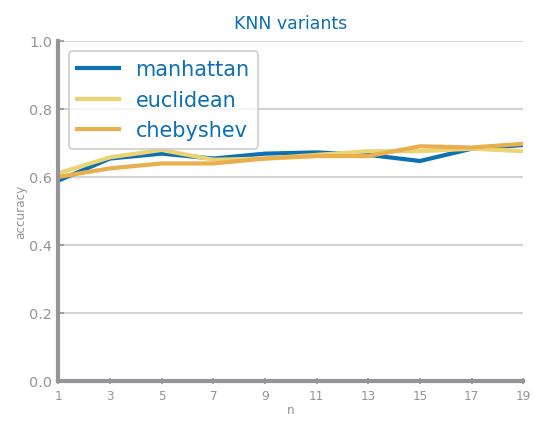

Best results with 19 neighbors and chebyshev


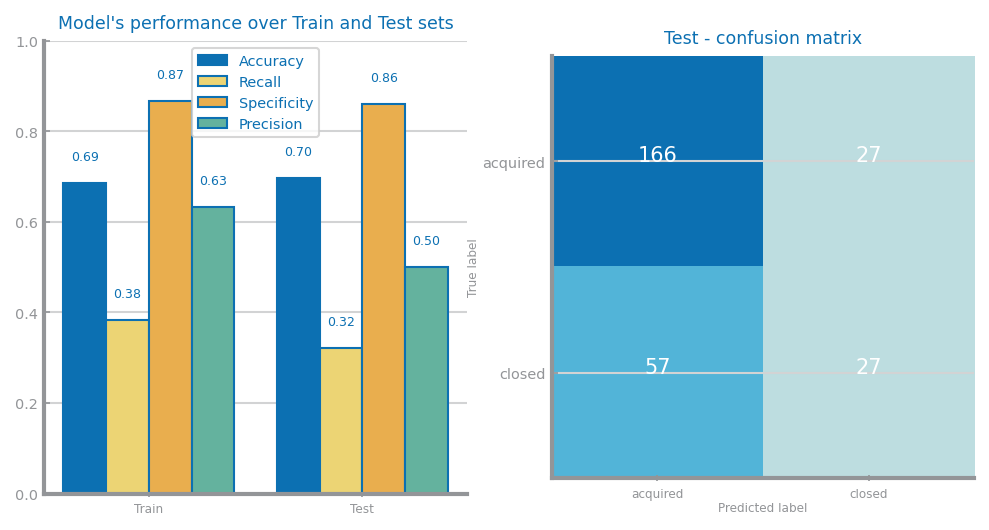

In [16]:
best_knn = midfunc.Knn_distances(data_mv_dummy,target,project_path)
midfunc.Knn_metrics(data_mv_dummy,target,project_path,best_knn)

## 02. <b>MV & DUMMY</b> | Naive Bayes Evaluation:


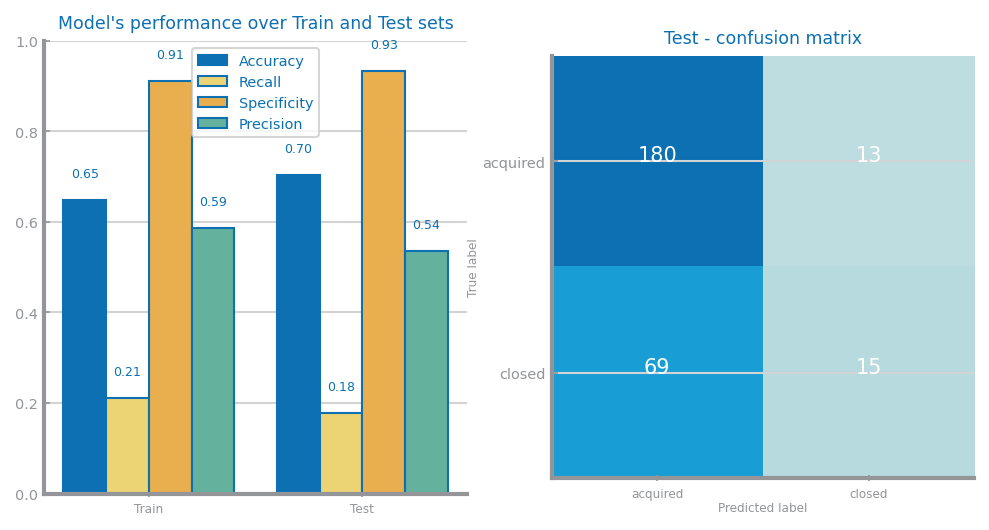

In [17]:
midfunc.Naive_bayes(data_mv_dummy,target,project_path)

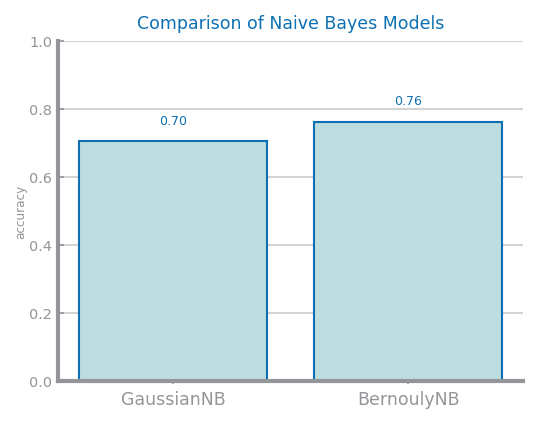

In [18]:
midfunc.Naive_bayes_estimators(data_mv_dummy, target, project_path)

## 03. Outliers:

1. Drop Negative values;
2. Put 0 as age on negative values;
3. Drop outlier record of 'funding_total_usd':

In [19]:
if treat_outliers:
    #1. Drop negative values:
    data_mv_dummy_out_1 = data_mv_dummy.copy(deep=True)
    data_mv_dummy_out_1[data_mv_dummy_out_1['age_first_funding_year'] >= 0]
    data_mv_dummy_out_1[data_mv_dummy_out_1['age_last_funding_year'] >= 0]
    data_mv_dummy_out_1[data_mv_dummy_out_1['age_first_milestone_year'] >= 0]
    data_mv_dummy_out_1[data_mv_dummy_out_1['age_last_milestone_year'] >= 0]

    #2. Replace the negative values with 0:
    data_mv_dummy_out_2 = data_mv_dummy.copy(deep=True)
    data_mv_dummy_out_2['age_first_funding_year'] = np.where(data_mv_dummy_out_2['age_first_funding_year'] < 0,0,data_mv_dummy_out_2['age_first_funding_year'])
    data_mv_dummy_out_2['age_last_funding_year'] = np.where(data_mv_dummy_out_2['age_last_funding_year'] < 0,0,data_mv_dummy_out_2['age_last_funding_year'])
    data_mv_dummy_out_2['age_first_milestone_year'] = np.where(data_mv_dummy_out_2['age_first_milestone_year'] < 0,0,data_mv_dummy_out_2['age_first_milestone_year'])
    data_mv_dummy_out_2['age_last_milestone_year'] = np.where(data_mv_dummy_out_2['age_last_milestone_year'] < 0,0,data_mv_dummy_out_2['age_last_milestone_year'])

    #3. Drop the outlier record of 'funding_total_usd':
    data_mv_dummy_out_3 = data_mv_dummy.copy(deep=True)
    data_mv_dummy_out_3 = data_mv_dummy_out_3.drop(data_mv_dummy_out_3['funding_total_usd'].idxmax())

    exec('data_mv_dummy_out =' + outliers_data)
else:
    data_mv_dummy_out = data_mv_dummy

data_mv_dummy_out.shape

(923, 38)

## 03. <b>MV & DUMMY & OUTLIERS</b> | KNN Evaluation:

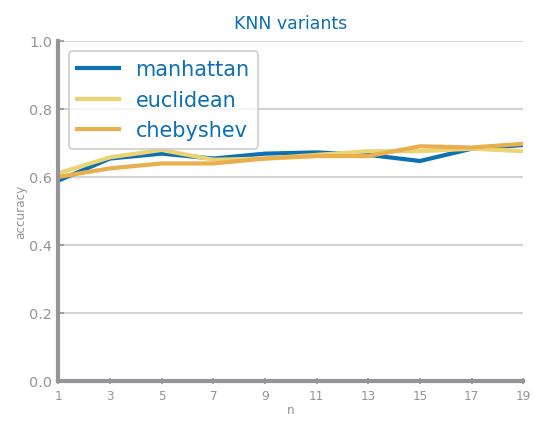

Best results with 19 neighbors and chebyshev


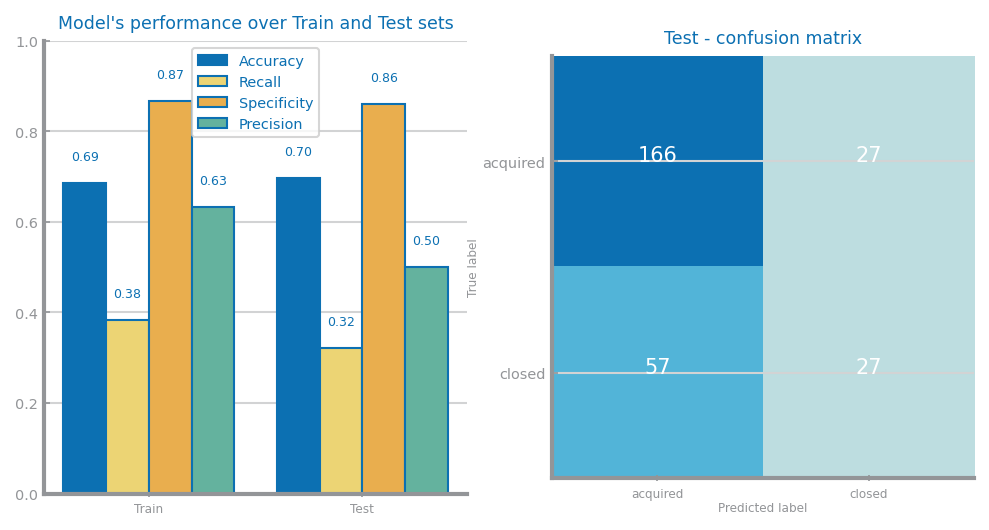

In [20]:
best_knn = midfunc.Knn_distances(data_mv_dummy_out,target,project_path)
midfunc.Knn_metrics(data_mv_dummy_out,target,project_path,best_knn)

## 03. <b>MV & DUMMY & OUTLIERS</b> | Naive Bayes Evaluation:


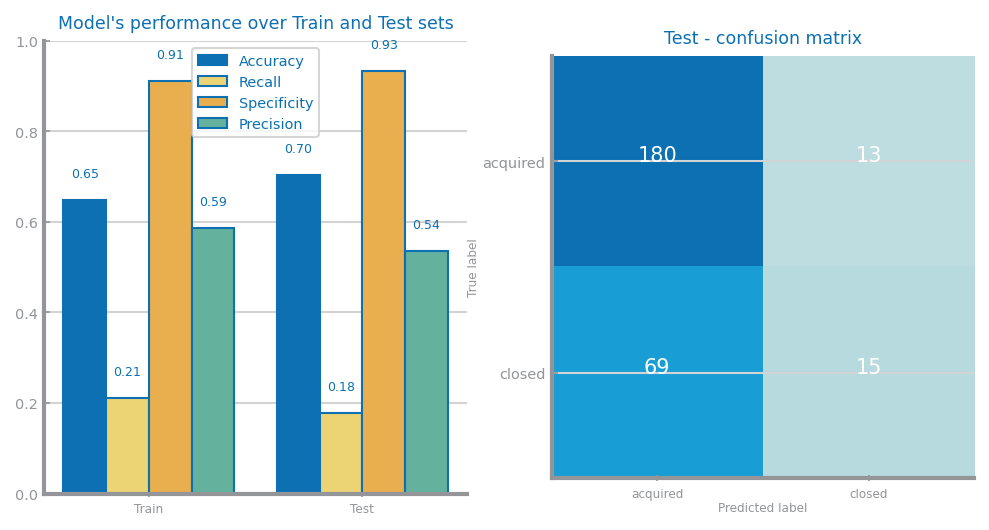

In [21]:
midfunc.Naive_bayes(data_mv_dummy_out, target, project_path)

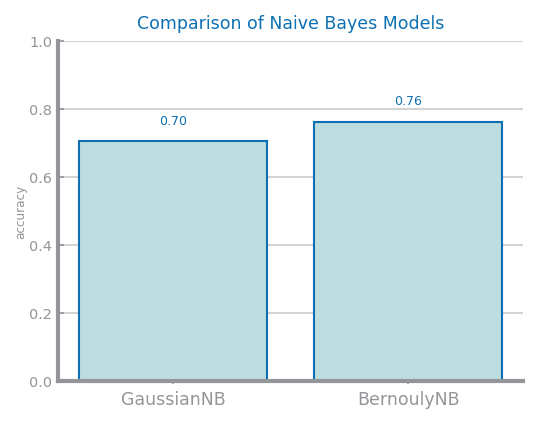

In [22]:
midfunc.Naive_bayes_estimators(data_mv_dummy_out, target, project_path)

## 04. Scaling:
1. Standard Scaler;
2. MinMax Scaler.

In [23]:
data_in = data_in.drop(columns=dummy_dropped_cols)
variable_types = get_variable_types(data_in)
numeric_vars = variable_types['numeric']
symbolic_vars = variable_types['symbolic']
boolean_vars = variable_types['binary']
date_vars = variable_types['date']
numeric_vars.remove('closed_at')

if drop_closed_at == False:
    date_vars.append('closed_at')

df_nr = data_mv_dummy_out[numeric_vars]
df_sb = data_mv_dummy_out[symbolic_vars]
df_bool = data_mv_dummy_out[boolean_vars]
df_dates = data_mv_dummy_out[date_vars]

### 04.1. <b>Standard Scaler</b>

The Standard Scaler implements the z-score transformation (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

In [24]:
transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), columns= numeric_vars)
transf_sb = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_sb)
tmp_sb = DataFrame(transf_sb.transform(df_sb), columns= symbolic_vars)
#transf_dt = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_dates)
#tmp_dt = DataFrame(transf_dt.transform(df_dates), columns= date_vars)
norm_data_zscore = concat([tmp, tmp_sb,  df_bool, df_dates], axis=1)
norm_data_zscore.shape

(923, 38)

### 04.2 <b> MinMax Scaler </b>
And then we do the same with the MinMaxScaler. Note the use of the parameter copy on both scalers, in order to keep the original data untouched.

In [25]:
transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
transf_sb = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_sb)
#transf_dt = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_dates)
tmp = DataFrame(transf.transform(df_nr), columns= numeric_vars)
tmp_sb = DataFrame(transf_sb.transform(df_sb), columns= symbolic_vars)
#tmp_dt = DataFrame(transf_dt.transform(df_dates), columns= date_vars)
norm_data_minmax = concat([tmp, tmp_sb,  df_bool, df_dates], axis=1)
norm_data_minmax.shape

(923, 38)

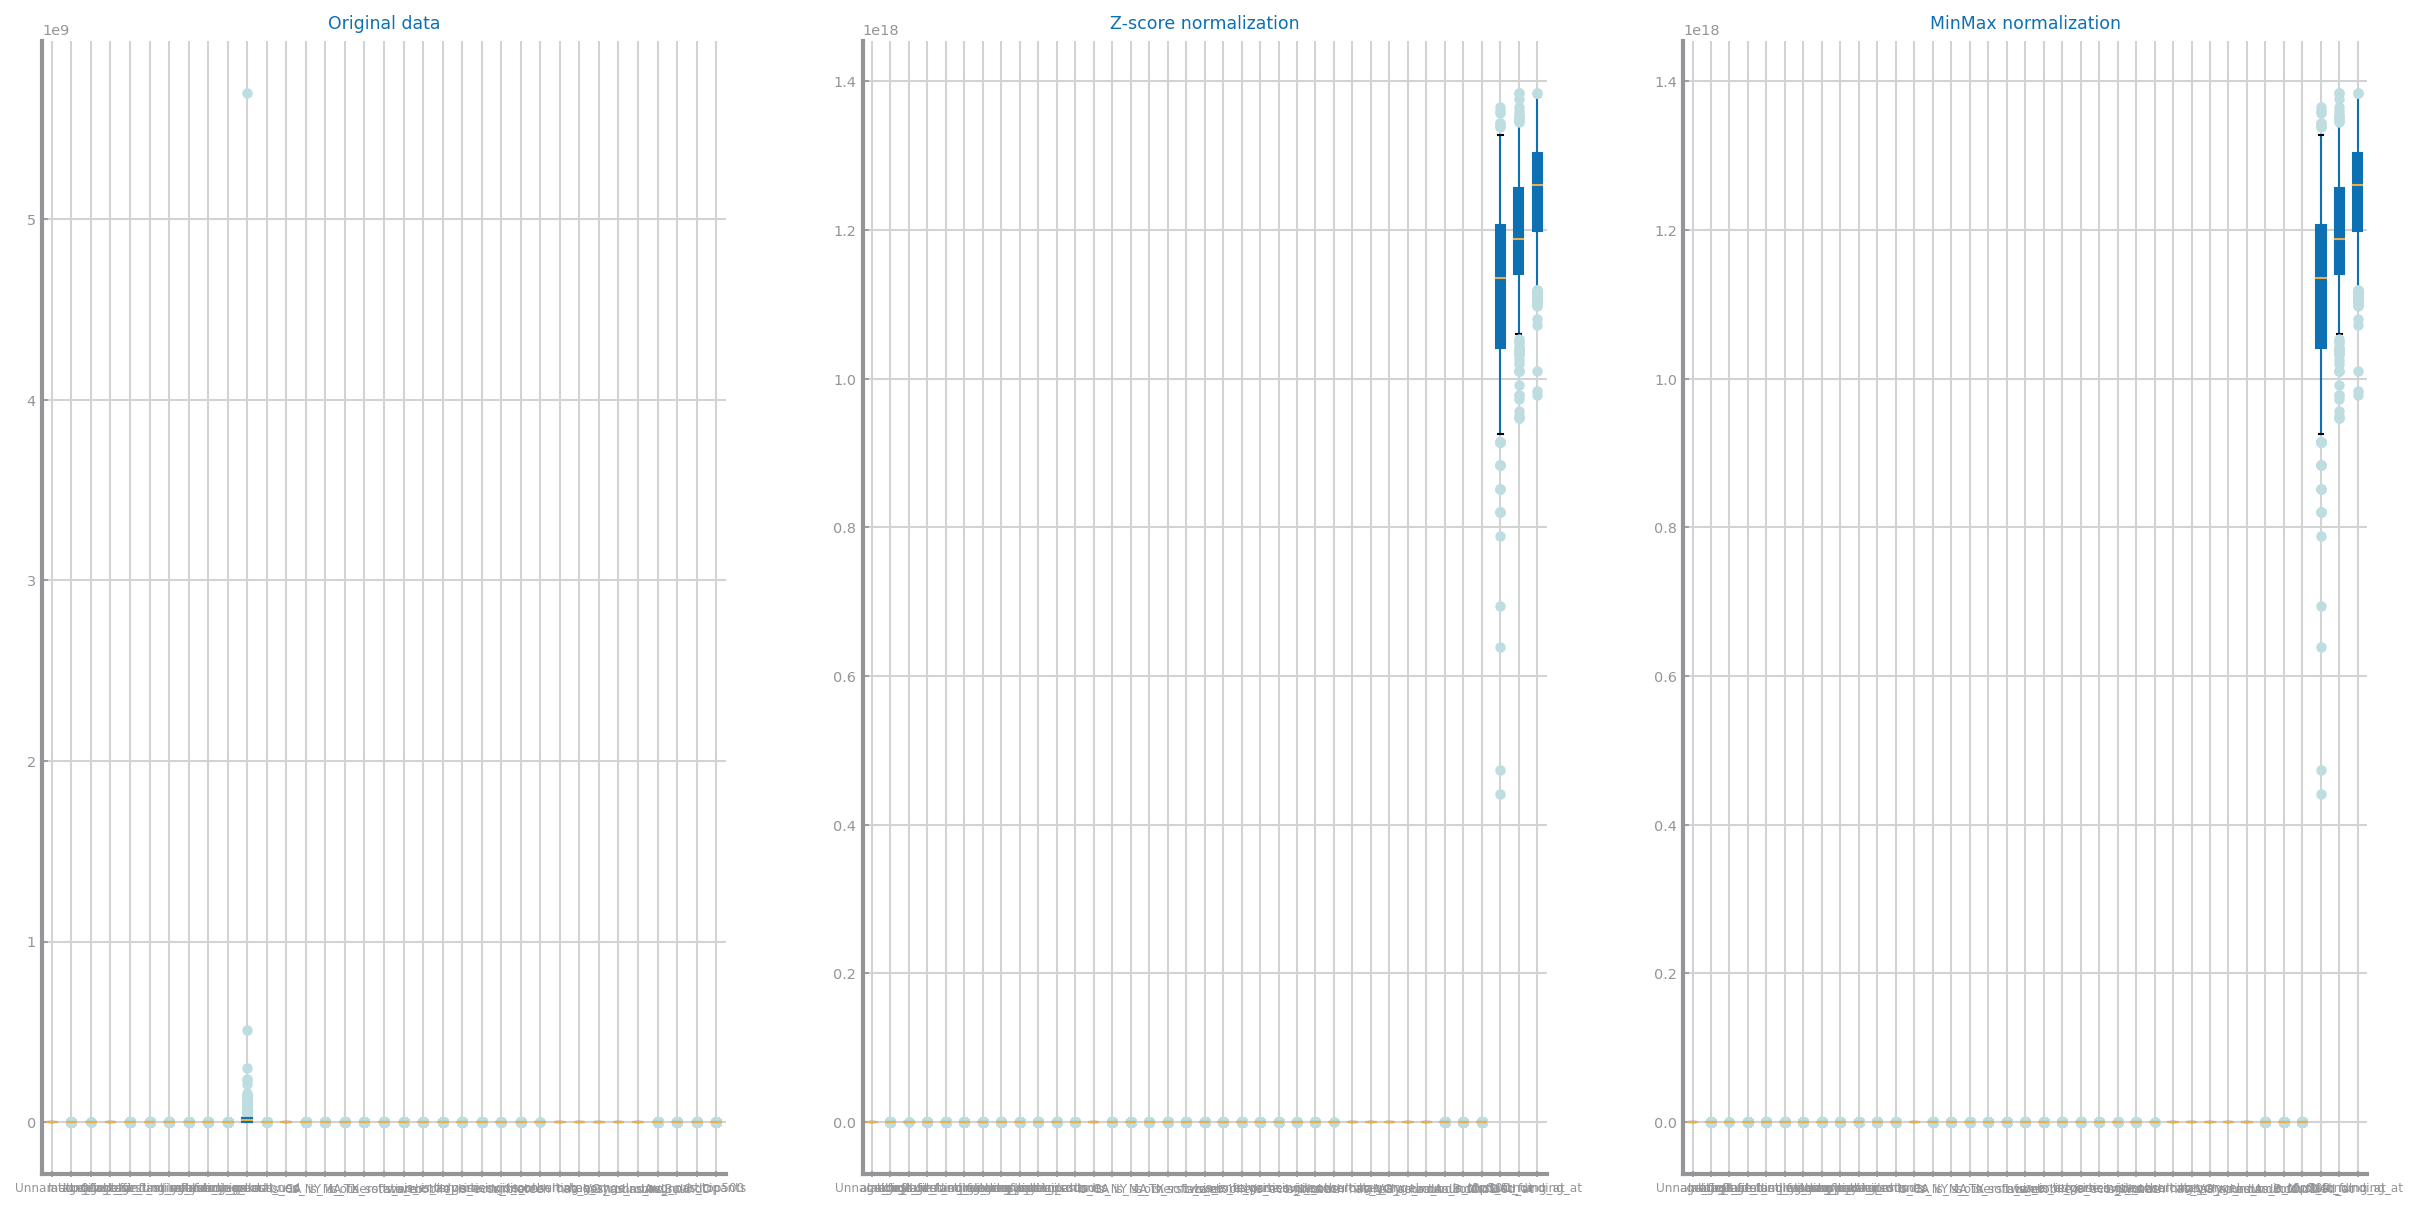

In [26]:
fig, axs = subplots(1, 3, figsize=(20,10),squeeze=False)
axs[0, 0].set_title('Original data')
data.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title('MinMax normalization')
norm_data_minmax.boxplot(ax=axs[0, 2])
show()

In [27]:
if scale_data:
    exec('data_scaled =' + scaled_data)
else:
    exec('data_scaled =' + data_mv_dummy_out)

## 04. <b>MV & DUMMY & OUTLIERS & SCALING</b> | KNN Evaluation:

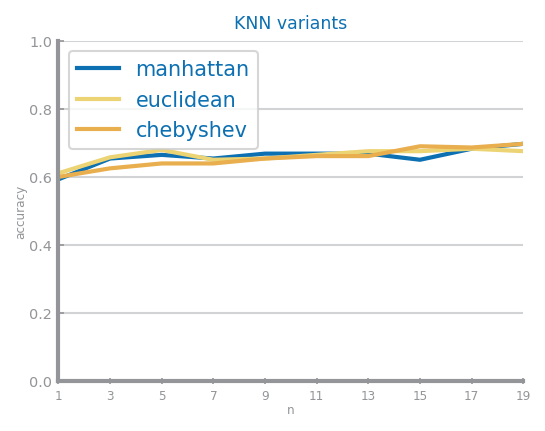

Best results with 19 neighbors and manhattan


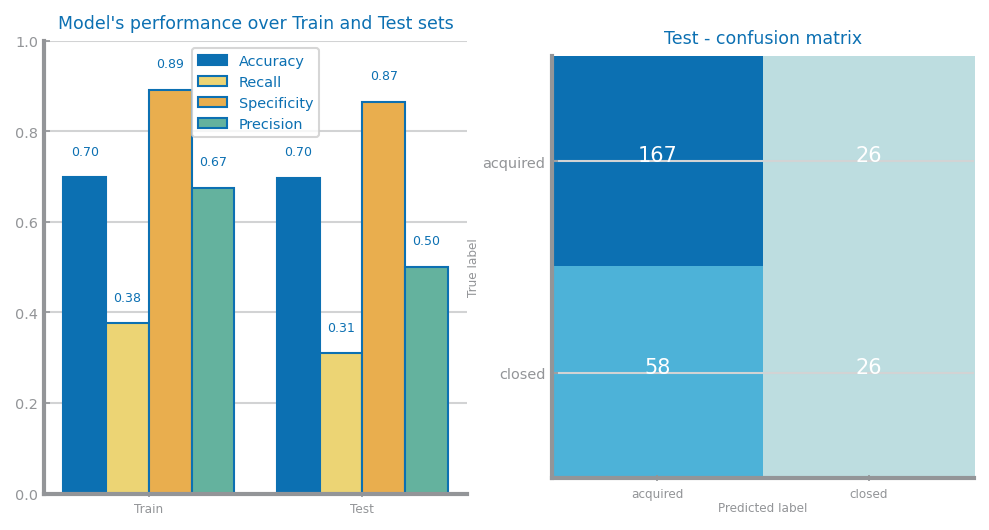

In [28]:
best_knn = midfunc.Knn_distances(data_scaled, target, project_path)
midfunc.Knn_metrics(data_scaled, target, project_path, best_knn)

## 04. <b>MV & DUMMY & OUTLIERS & SCALED</b> | Naive Bayes Evaluation:


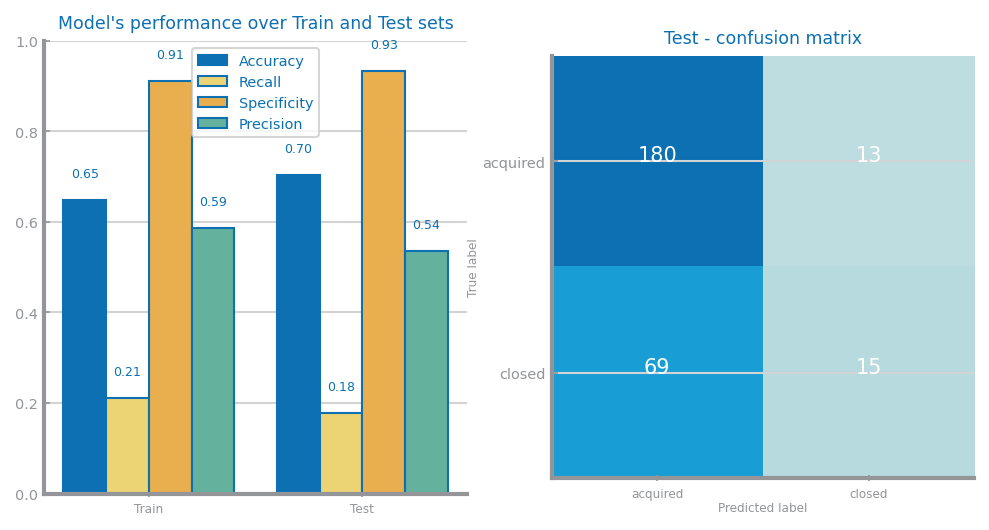

In [29]:
midfunc.Naive_bayes(data_scaled, target, project_path)

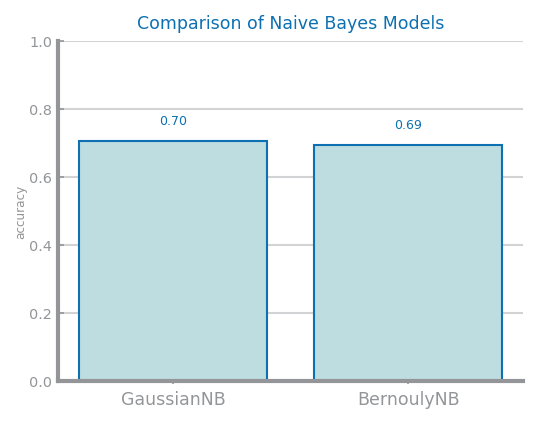

In [30]:
midfunc.Naive_bayes_estimators(data_scaled, target, project_path)

## 05. Data Balancing

In [31]:
trnX, trnY, tstX, tstY, labels, x_train, x_test, y_train, y_test = midfunc.Sample_split(data_scaled,target)

In [32]:
if balance_data:
    data_to_balance = pd.concat([x_train, y_train], axis=1).reindex(x_train.index)
else:
    print('No balance made.')

No balance made.


In [33]:
if balance_data:
    target_count = data_to_balance[target].value_counts()
    positive_class = target_count.idxmin()
    negative_class = target_count.idxmax()

    #ind_positive_class = target_count.index.get_loc(positive_class)
    print('Minority class=', positive_class, ':', target_count[positive_class])
    print('Majority class=', negative_class, ':', target_count[negative_class])
    print('Proportion:', round(target_count[positive_class] / target_count[negative_class], 2), ': 1')
    values = {'Original': [target_count[positive_class], target_count[negative_class]]}

    plt.figure()
    ds.bar_chart(target_count.index, target_count.values, title='Class balance')
    plt.savefig(project_path + '/images/startup_balanced.png')
    plt.show()
else:
    print('No balance made.')

No balance made.


Before proceeding, lets split the dataset into two subdatasets: one for each class. Then we can sample the required one and join to the other one, as we did on the other preparation techniques. In the end, we can write the dataset into a new datafile to explore later.

In [34]:
if balance_data:
    df_positives = data_to_balance[data_to_balance[target] == positive_class]
    df_negatives = data_to_balance[data_to_balance[target] == negative_class]
else:
    print('No balance made.')

No balance made.


We can follow two different strategies: undersampling and oversampling. The choice of each one of them, depends on the size of the dataset, i.e., the number of records to use as train:

- with a huge dataset, and consequently a considerable number of positve records, we can use an undersampling strategy, keeping the positive records and sampling the negative ones to balance the final distribution -
- in the presence of a small number of positive records, we need to apply oversampling, in order to create a larger set to support the training step.

### 05.1. UnderSampling:

In [35]:
if balance_data:
    df_neg_sample = DataFrame(df_negatives.sample(len(df_positives)))
    df_under = concat([df_positives, df_neg_sample], axis=0)
    #df_under.to_csv(project_path + '/data/qsar_oral_toxicity_under.csv', index=False)
    values['UnderSample'] = [len(df_positives), len(df_neg_sample)]
    print('Minority class=', positive_class, ':', len(df_positives))
    print('Majority class=', negative_class, ':', len(df_neg_sample))
    print('Proportion:', round(len(df_positives) / len(df_neg_sample), 2), ': 1')
else:
    print('No balance made.')

No balance made.


This implements undersampling, and in a similar way, we get oversampling by replication. Note on the replace parameter in the sample method, which means that we are taking a sample with replacement, meaning that we pick the same record more than once.

### 05.2. OverSampling:

In [36]:
if balance_data:
    df_pos_sample = DataFrame(df_positives.sample(len(df_negatives), replace=True))
    df_over = concat([df_pos_sample, df_negatives], axis=0)
    #df_over.to_csv(filespath + '/data/qsar_oral_toxicity_over.csv', index=False)
    values['OverSample'] = [len(df_pos_sample), len(df_negatives)]
    print('Minority class=', positive_class, ':', len(df_pos_sample))
    print('Majority class=', negative_class, ':', len(df_negatives))
    print('Proportion:', round(len(df_pos_sample) / len(df_negatives), 2), ': 1')

    plt.figure()
    ds.multiple_bar_chart([positive_class, negative_class], values,
                        title='Target', xlabel='frequency', ylabel='Class balance')
else:
    print('No balance made.')

No balance made.


### 05.3. Smote:
Among the different oversampling strategies there is SMOTE, one of the most interesting ones. In this case, the oversample is created from the minority class, by artificially creating new records in the neighborhood of the positive records.

It is usual to adopt a hybrid approach, by choosing a number of records between the number of positives and negatives, say N. This however implies taking a sample from the negatives with N records, and generating the new positives ones reaching the same number of records.

In [37]:
if balance_data:
    RANDOM_STATE = 42

    data_to_balance[target]

    smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
    y = data_to_balance.pop(target).values
    X = data_to_balance.values
    smote_X, smote_y = smote.fit_resample(X, y)
    df_smote = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)
    df_smote.columns = list(data_to_balance.columns) + [target]
    #df_smote.to_csv(filespath + '/data/qsar_oral_toxicity_smote.csv', index=False)

    smote_target_count = pd.Series(smote_y).value_counts()
    values['SMOTE'] = [smote_target_count[positive_class], smote_target_count[negative_class]]
    print('Minority class=', positive_class, ':', smote_target_count[positive_class])
    print('Majority class=', negative_class, ':', smote_target_count[negative_class])
    print('Proportion:', round(smote_target_count[positive_class] / smote_target_count[negative_class], 2), ': 1')

    df_smote.describe()
else:
    print('No balance made.')

No balance made.


See, that for SMOTE method we have to split the original data into two: one with just one variable - the class variable, call it y, and another with all the other variables, call it X (look at the Classification lab for more details about this). Then the SMOTE technique generates the positive records, don't needing to join the positive and negatives ones. Indeed, what we have to do is just rejoin the data (smote_X) with the corresponding class (smote_y), already updated.

In [38]:
if balance_data:
    plt.figure()
    ds.multiple_bar_chart([positive_class, negative_class], values,
                        title='Target', xlabel='frequency', ylabel='Class balance')
    plt.show()
else:
    print('No balance made.')

No balance made.


In [39]:
if balance_data:
    exec('data_balanced_train =' + balanced_data)
    data_test = pd.concat([x_test, y_test], axis=1).reindex(x_test.index)
else:
    print('No balance made.')
    data_balanced_train = pd.concat([x_train, y_train], axis=1).reindex(x_train.index)
    data_test = pd.concat([x_test, y_test], axis=1).reindex(x_test.index)

No balance made.


## 05.4. <b>MV & DUMMY & OUTLIERS & SCALED & BALANCED</b> | KNN Evaluation:

In [40]:
if balance_data:
    x_train = data_balanced_train.drop(columns=target)
    y_train = data_balanced_train[target]

    trnY: np.ndarray = y_train.values
    trnX: np.ndarray = x_train.values
    labels = pd.unique(trnY)

    nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
    dist = ['manhattan', 'euclidean', 'chebyshev']
    values = {}
    best = (0, '')
    last_best = 0
    for d in dist:
        yvalues = []
        for n in nvalues:
            knn = KNeighborsClassifier(n_neighbors=n, metric=d)
            knn.fit(trnX, trnY)
            prdY = knn.predict(tstX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            if yvalues[-1] > last_best:
                best = (n, d)
                last_best = yvalues[-1]
        values[d] = yvalues

    plt.figure()
    ds.multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
    plt.savefig(project_path + '/images/finance_knn_study.png')
    plt.show()
    print('Best results with %d neighbors and %s'%(best[0], best[1]))
else:
    print('No balance made.')


No balance made.


In [41]:
if balance_data:
    HEIGHT: int = 4
    def plot_evaluation_results(labels: ndarray, trn_y, prd_trn, tst_y, prd_tst):
        cnf_mtx_trn = metrics.confusion_matrix(y_true=trn_y, y_pred=prd_trn, labels=labels)
        tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
        cnf_mtx_tst = metrics.confusion_matrix(y_true=tst_y, y_pred=prd_tst, labels=labels)
        tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()

        evaluation = {'Accuracy': [(tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn),
                                (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)],
                    'Recall': [tp_trn / (tp_trn + fn_trn), tp_tst / (tp_tst + fn_tst)],
                    'Specificity': [tn_trn / (tn_trn + fp_trn), tn_tst / (tn_tst + fp_tst)],
                    'Precision': [tp_trn / (tp_trn + fp_trn), tp_tst / (tp_tst + fp_tst)]}

        fig, axs = plt.subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
        ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets",
                        percentage=True)
        ds.plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[1], title='Test')

    clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
    clf.fit(trnX, trnY)
    prd_trn = clf.predict(trnX)
    prd_tst = clf.predict(tstX)
    plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
    plt.savefig(project_path + '/images/finance_knn_best.png')
    plt.show()
else:
    print('No balance made.')

No balance made.


## 05.5. <b>MV & DUMMY & OUTLIERS & SCALED & BALANCED</b> | Naive Bayes Evaluation:


In [42]:
if balance_data: 
    HEIGHT: int = 4
    def plot_evaluation_results(labels: ndarray, trn_y, prd_trn, tst_y, prd_tst):
        cnf_mtx_trn = metrics.confusion_matrix(y_true=trn_y, y_pred=prd_trn, labels=labels)
        tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
        cnf_mtx_tst = metrics.confusion_matrix(y_true=tst_y, y_pred=prd_tst, labels=labels)
        tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()

        evaluation = {'Accuracy': [(tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn),
                                (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)],
                    'Recall': [tp_trn / (tp_trn + fn_trn), tp_tst / (tp_tst + fn_tst)],
                    'Specificity': [tn_trn / (tn_trn + fp_trn), tn_tst / (tn_tst + fp_tst)],
                    'Precision': [tp_trn / (tp_trn + fp_trn), tp_tst / (tp_tst + fp_tst)]}

        fig, axs = plt.subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
        ds.multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets",
                        percentage=True)
        ds.plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[1], title='Test')

    clf = GaussianNB()
    clf.fit(trnX, trnY)
    prd_trn = clf.predict(trnX)
    prd_tst = clf.predict(tstX)
    plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)
    plt.savefig(project_path + '/images/finance_nb_best.png')
    plt.show()
else:
    print('No balance made.')

No balance made.


In [43]:
if balance_data:
    estimators = {'GaussianNB': GaussianNB(),
              #'MultinomialNB': MultinomialNB(),     NOT POSSIBLE TO RUN DUE TO THE EXISTENCE OF NEGATIVE VALUES
              'BernoulyNB': BernoulliNB()}

    xvalues = []
    yvalues = []
    for clf in estimators:
        xvalues.append(clf)
        estimators[clf].fit(trnX, trnY)
        prdY = estimators[clf].predict(tstX)
        yvalues.append(metrics.accuracy_score(tstY, prdY))

    plt.figure()
    ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
    plt.savefig(project_path + '/images/finance_nb_study.png')
    plt.show()
else:
    print('No balance made.')

No balance made.


# Export Train & Test dataframes to CSV:

In [44]:
if drop_closed_at:
    data_out_train = pd.merge(data_balanced_train, data_closed_at, left_index=True, right_index=True)
    data_out_test = pd.merge(data_test, data_closed_at, left_index=True, right_index=True)
else:
    data_out_train = data_balanced_train.copy()
    data_out_test = data_test.copy()

In [45]:
data_out_train.to_csv(project_path + prepared_out_data_file_train, index=False)
data_out_test.to_csv(project_path + prepared_out_data_file_test, index=False)